# Annotated MNIST Digit Classifier
This network uses the simple backpropigation algorithm outlined in: https://arxiv.org/pdf/2301.09977

This model doesn't work. This method of calculating gradients is costly and I was unable to train an effective classifier. My previous attempt at ~80% performed much better. Hopefully I'll be able to learn some more and come back to this and understand why it doesn't work.

In [1]:
import pandas as pd
import numpy as np

### Import MNIST dataset using tensorflow

The tensorflow library is only used to import the data, the rest of the network is done with just numpy and math

In [2]:
import tensorflow as tf

# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the dataset
x_train, x_test = x_train / 255.0, x_test / 255.0

# Access the images
images = x_train

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# simple funcion to display an input as a picture
import numpy as np
import matplotlib.pyplot as plt

def show_image(matrix, y):
    # Ensure the input is a 28x28 NumPy array
    if matrix.shape != (28, 28):
        raise ValueError("Input matrix must be of shape (28, 28)")

    # Display the image
    plt.figure(figsize=(2, 2))
    plt.imshow(matrix, cmap='gray', interpolation='nearest')
    plt.title(f"Labled as {y}")
    plt.colorbar()  # Optional: to show the color scale
    plt.show()

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
y_train.shape

(60000,)

In [4]:
## 1 hot encoding single example
# x is a scalar
def one_hot_encode(x):
  vector = np.zeros((10, 1))
  vector[x-1] = 1
  return vector

### Shape input to the correct dimensions

We want y_train and test 1-hot encoded and x_train and x_test vectorized

In [5]:
# 1h encode y_train
y_train_labels = one_hot_encode(y_train[0])
for ex in y_train[1:]:
  y_train_labels = np.hstack((y_train_labels, one_hot_encode(ex)))

print(y_train_labels.shape)

# 1h encode y_test
y_test_labels = one_hot_encode(y_test[0])
for ex in y_test[1:]:
  y_test_labels = np.hstack((y_test_labels, one_hot_encode(ex)))

print(y_test_labels.shape)

(10, 60000)
(10, 10000)


In [6]:
x_train_final = x_train.reshape(60000, 28 * 28)
x_train_final.shape

(60000, 784)

In [65]:
x_test.shape

(10000, 28, 28)

In [7]:
x_test_final = x_test.reshape(10000, 28 * 28)
x_test_final.shape

(10000, 784)

### Define structure of neural network
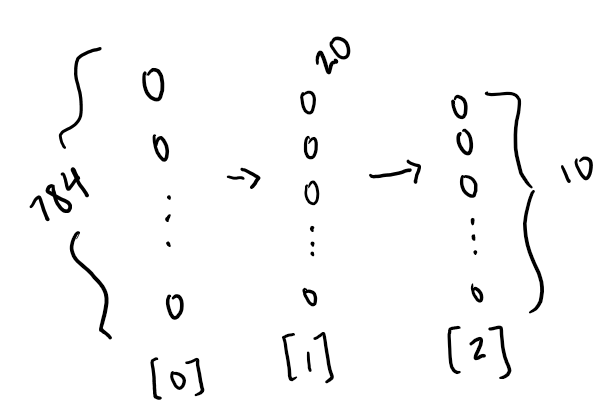

In [8]:
# structure of nn will be 784 -> 20 -> 10
nodes_l0 = 784
nodes_l1 = 20
nodes_l2 = 10

### Define parameters
$W^1\in \mathbb{R^{784 x 20}}$, $b^1\in \mathbb{R^{20}}$ are the weights and biases that transform input, $x=a_0$ into $z^1$, the weighted input of layer 1

$a_1 = ReLu((W^1)^Ta_0+b^1)$
<br><br>

$W^2\in \mathbb{R^{20 x 10}}$, $b^2\in \mathbb{R^{10}}$ are defined similarly for layer 2

$a_2 = Softmax((W^2)^Ta_1+b^2)$

<br>
$\theta ^T = \begin{bmatrix}(vec(W^1))^T & (b^1)^T & (vec(W^2))^T & (b^2)^T \end{bmatrix}$

In [37]:
# define random weights, biases
np.random.seed(42)
original_theta = np.random.rand(nodes_l1 + nodes_l2 + (nodes_l0*nodes_l1) + (nodes_l1*nodes_l2)).reshape(-1, 1)
theta = original_theta.copy()

# these variables function as pointers to the relevent entries of theta
weights_l1 = theta[0:nodes_l0*nodes_l1]
bias_l1 = theta[nodes_l0*nodes_l1:(nodes_l0*nodes_l1) + nodes_l1]
weights_l2 = theta[(nodes_l0*nodes_l1)+nodes_l1:((nodes_l0*nodes_l1)+nodes_l1) + (nodes_l1*nodes_l2)]
bias_l2 = theta[(((nodes_l0*nodes_l1)+nodes_l1) + (nodes_l1*nodes_l2)):(((nodes_l0*nodes_l1)+nodes_l1) + (nodes_l1*nodes_l2)) + nodes_l2]

weights_l1 = weights_l1.reshape(nodes_l0, nodes_l1)
bias_l1 = bias_l1.reshape(nodes_l1, 1)
weights_l2 = weights_l2.reshape(nodes_l1, nodes_l2)
bias_l2 = bias_l2.reshape(nodes_l2, 1)


print(theta.size)
print(bias_l1.size)
print(bias_l2.size)
print(weights_l1.size)
print(weights_l2.size)
print(bias_l1.size + bias_l2.size + weights_l1.size + weights_l2.size)

15910
20
10
15680
200
15910


### Define Relu and Softmax

In [10]:
def relu(x):
  return np.maximum(0, x)

def relu_prime(x):
  return np.where(x > 0, 1, 0)

In [11]:
# running into overflow with classical implementation
# subtract max for numerical stability - doesn't affect gradients
def softmax_imp(x):
    x_max = np.max(x)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x)

### Define a Forward Pass through the network

In [12]:
# forward pass through the network
# x is a vector of length 784
# returns tuple of activations and z's throughout network
def forward_eval(x):
  if x.shape != (nodes_l0, 1):
    print("Input wrong dimension")
    return -1

  a0 = x

  z1 = (weights_l1.transpose() @ a0) + bias_l1
  a1 = relu(z1)

  z2 = (weights_l2.transpose() @ a1) + bias_l2
  a2 = softmax_imp(z2)

  return x, a0, z1, a1, z2, a2

### Backpropagation
Find gradient of a single example i. Let $\hat{y}$ be $a2$ and y be the one hot encoded label associated with the input that produced $\hat{y}$

$\nabla_\theta L(y, \hat{y}) = \begin{bmatrix}J_\theta L(y, \hat{y})\end{bmatrix}^T = \begin{bmatrix}J_\theta L(y, Softmax(z^2))\end{bmatrix}^T$

$= \begin{bmatrix} J_{z^2} L(y, Softmax(z^2)) & J_\theta z^2(\theta) \end{bmatrix}^T$

$= (J_\theta z^2(\theta))^T (J_{z^2} L(y, Softmax(z^2)))^T$

$= (J_\theta z^2(\theta))^T \nabla _{z^L} L(y, Softmax(z^2)))$

We obtain an expression for the gradient with respect to theta (the ultimate gradient that we're looking for) in simpler terms that we can furhter solve for. A more detailed explaination of this derivation can be found in the aforementioned paper.
<br><br><br>

$\nabla _{z^L} L(y, Softmax(z^2))) = -(y-\hat{y})$

The derivations for this are also outlined in the paper. I worked them out myself in a bit of a different way but chose not to include becuase this is a very common result and I didn't want to clutter up the notebook.
<br><br><br>

$J_\theta z^2(\theta) = \begin{bmatrix} J_{w^1, b^1}(z^2(\theta)) & J_{W^2, b^2}(z^2(\theta))\end{bmatrix}$

$= \begin{bmatrix} (W^2)^T diag(\delta_1, …, \delta_{20})\begin{bmatrix} a_0^T & \dots & 0 \\ 0 & \ddots && I_{20x20}\\ \vdots && a_0^T\end{bmatrix} & \begin{bmatrix} a_1^T & \dots & 0 \\ 0 & \ddots && I_{10x10}\\ \vdots && a_1^T\end{bmatrix}\end{bmatrix}$

where $δ_i = 1$ when $z_i^1 > 0$ and $δ_i = 0$ when $z_i^1 \leq 0$ (derivative of $ReLu(z)$)


These derivations are taken almost directly from the paper, just replacing arbirary dimensions for the specifics of my network and expanding upon the ReLu activation function.
<br><br>


$\nabla_\theta L(y, \hat{y}) = -\begin{bmatrix} \begin{bmatrix} a_0 && 0 \\ &\ddots \\ 0 && a_0 \\ & I_{20x20}\end{bmatrix} diag(\delta_1, \dots, \delta_{20}) W^2 \\ \begin{bmatrix} a_1 && 0 \\ &\ddots \\ 0 && a_1 \\ & I_{10x10}\end{bmatrix}\end{bmatrix} (y-\hat{y})$

Finally, we obtain the formula that we code up to use in gradient descent.

In [35]:
# input - (784x1)
# label - (10x1)
# relu_prime takes z vector

def backprop(input, label):
  x, a0, z1, a1, z2, a2 = forward_eval(input)

  if label.shape != (nodes_l2, 1):
      print("Shape of label wrong size:")
      print(label.shape)
      return -1

  diag_theta = relu_prime(z1)
  diag_theta = np.diag(diag_theta.flatten())

  first_matrix = np.pad(a0, ((0, (784*19)), (0, 0)), 'constant')
  for i in range(1, 20):
    first_matrix = np.hstack((first_matrix, np.pad(a0, ((i*784, (19-i)*784), (0, 0)))))
  first_matrix = np.vstack((first_matrix, np.eye(20)))

  second_matrix = np.pad(a1, ((0, (20*9)), (0, 0)), 'constant')
  for i in range(1, 10):
    second_matrix = np.hstack((second_matrix, np.pad(a1, ((i*20, (9-i)*20), (0, 0)))))
  second_matrix = np.vstack((second_matrix, np.eye(10)))

  top_matrix = first_matrix @ diag_theta
  top_matrix = top_matrix @ weights_l2

  matrix = np.vstack((top_matrix, second_matrix))

  error = a2 - label

  grad = matrix @ error
  grad = grad

  return grad, np.mean(np.abs(z2 - label))





In [14]:
# gradient descent
def gradient_descent(learning_rate, X, y):
    global theta

    gradients = np.zeros_like(theta)
    costs = []

    # gather matrix of gradients from each example i
    for i in range(X.shape[0]):
        grad, cost = backprop(X[i, :].reshape(784, 1), y[:, i].reshape(-1, 1))
        gradients += grad
        costs.append(cost)

    # average -> obtain final gradient -> update theta
    gradients /= X.shape[0]
    theta -= learning_rate * gradients

    print(f"Updated theta with lr {learning_rate}")
    print(f"Average cost of these examples: {np.mean(costs)}")

    return np.mean(costs)


In [ ]:
# x_train_final, y_train_labels, x_test_final, y_test_labels

In [15]:
import random
import matplotlib.pyplot as plt
## Train network
def train(schedule, X, y):
  costs_list = []
  for learning_rate in schedule:
    # chose 32 random examples to use to calculate gradient each epoch
    examples = random.sample(range(X.shape[0]), 64)
    X_sgd = X[examples, :]
    y_sgd = y[:, examples]
    cost = gradient_descent(learning_rate, X_sgd, y_sgd)
    costs_list.append(cost)

  # Generate a plot to show how loss changed over epochs
  indices = list(range(len(costs_list)))

  # Create a scatter plot
  plt.scatter(indices, costs_list)
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.title('Scatter Plot of Average Loss Over Epochs')
  plt.show()

In [ ]:
print(x_train_final.shape)
print(y_train_labels.shape)

(60000, 784)
(10, 60000)


Updated theta with lr 0.01
Average cost of these examples: 486.67438986333536
Updated theta with lr 0.01
Average cost of these examples: 462.57676441613296
Updated theta with lr 0.01
Average cost of these examples: 478.122348899248
Updated theta with lr 0.01
Average cost of these examples: 457.45069375290205
Updated theta with lr 0.01
Average cost of these examples: 456.11068734221215
Updated theta with lr 0.01
Average cost of these examples: 476.9005665954139
Updated theta with lr 0.01
Average cost of these examples: 453.7922430048561
Updated theta with lr 0.01
Average cost of these examples: 449.49108129398076
Updated theta with lr 0.01
Average cost of these examples: 410.3286450605068
Updated theta with lr 0.01
Average cost of these examples: 437.6772676192652
Updated theta with lr 0.01
Average cost of these examples: 448.3084749032462
Updated theta with lr 0.01
Average cost of these examples: 440.75273641083123
Updated theta with lr 0.01
Average cost of these examples: 470.47985533

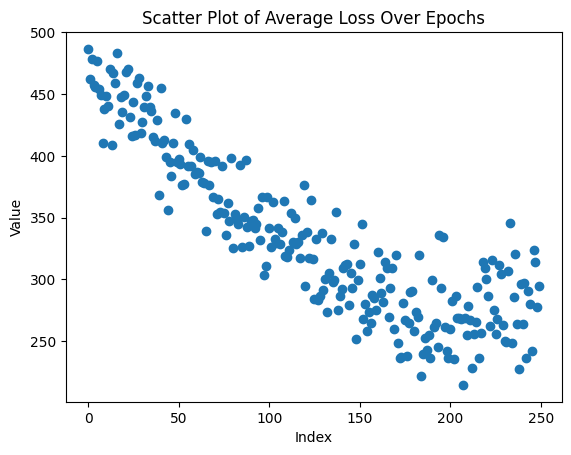

In [38]:
# epochs
schedule = np.full(250, 0.01)
#schedule_2 = np.full(200, 0.001)
#schedule = np.hstack((schedule, schedule_2))

# Concatenate the two vectors
#schedule = np.concatenate((vector_1, vector_2))

train(schedule, x_train_final, y_train_labels)

In [39]:
# predict single test example using network
def predict(x, y):
  if x.shape != (nodes_l0, 1):
    print("input wrong size")
    return -1

  z0_, a0_, z1_, a1_, z2_, a2_ = forward_eval(x)

  prediction = (np.argmax(a2_) + 1)%10

  print(f"prediction: {prediction}")
  print("distribution:")
  print(a2_)
  show_image(x.reshape(1, 28, 28)[0], y)

def predict_for_scoring(x):
  if x.shape != (nodes_l0, 1):
    print("input wrong size")
    return -1

  z0_, a0_, z1_, a1_, z2_, a2_ = forward_eval(x)

  prediction = (np.argmax(a2_) + 1)%10
  return prediction


In [ ]:
original_theta

array([[0.37454012],
       [0.95071431],
       [0.73199394],
       ...,
       [0.14418946],
       [0.20440377],
       [0.24626572]])

In [ ]:
theta

array([[-0.40606195],
       [ 0.43011278],
       [ 0.10895235],
       ...,
       [-0.41106221],
       [ 0.98190001],
       [ 1.02017274]])

prediction: 3
distribution:
[[8.23065417e-49]
 [4.23863114e-04]
 [9.99573476e-01]
 [6.14856352e-16]
 [1.80077325e-41]
 [8.14190143e-29]
 [2.66092634e-06]
 [1.02828855e-11]
 [1.43341448e-60]
 [1.96551480e-33]]


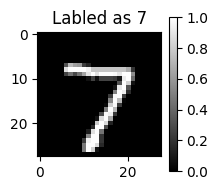

prediction: 8
distribution:
[[6.56946903e-083]
 [2.10565609e-001]
 [5.07257843e-005]
 [3.94411353e-029]
 [6.67747774e-054]
 [6.62725771e-045]
 [2.85504292e-002]
 [7.60833236e-001]
 [1.15990215e-102]
 [4.21553682e-060]]


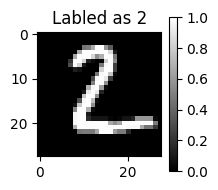

prediction: 3
distribution:
[[5.77663680e-29]
 [6.44923165e-10]
 [9.99999982e-01]
 [8.04634795e-12]
 [1.62557563e-25]
 [6.56898614e-20]
 [1.76403207e-08]
 [3.68221843e-15]
 [1.54009066e-29]
 [8.91090403e-18]]


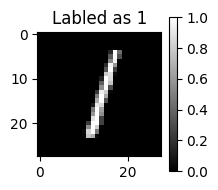

prediction: 8
distribution:
[[1.39433864e-117]
 [2.80513871e-018]
 [1.21404661e-027]
 [3.30231995e-048]
 [3.07356882e-064]
 [3.59483999e-062]
 [6.82514007e-012]
 [1.00000000e+000]
 [2.17709855e-131]
 [2.00856613e-079]]


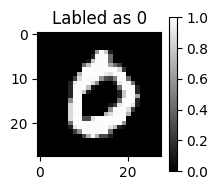

prediction: 8
distribution:
[[3.39326645e-55]
 [1.01275818e-07]
 [4.09826431e-02]
 [9.27122258e-20]
 [4.17673399e-29]
 [1.06245305e-26]
 [4.59127029e-01]
 [4.99890226e-01]
 [2.16423275e-59]
 [2.58382374e-34]]


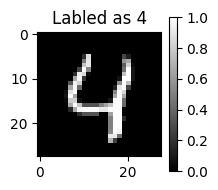

prediction: 3
distribution:
[[3.98929879e-42]
 [1.25506950e-06]
 [9.34952808e-01]
 [1.05788770e-13]
 [2.88456345e-24]
 [6.92998925e-21]
 [6.44957794e-02]
 [5.50157519e-04]
 [8.20603028e-39]
 [1.09404307e-22]]


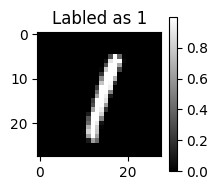

prediction: 3
distribution:
[[4.50879770e-54]
 [5.96671020e-10]
 [9.99999999e-01]
 [1.11449376e-17]
 [1.25018514e-48]
 [8.06066382e-35]
 [1.70107285e-10]
 [1.88327877e-16]
 [1.80882167e-62]
 [3.39307913e-35]]


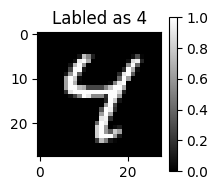

prediction: 8
distribution:
[[1.15465468e-62]
 [6.33546126e-07]
 [2.71212180e-06]
 [2.24809053e-23]
 [1.97211608e-34]
 [9.33426834e-32]
 [6.30170262e-02]
 [9.36979628e-01]
 [2.72168593e-65]
 [1.27410104e-36]]


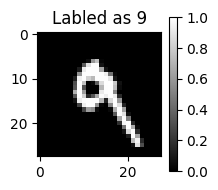

prediction: 8
distribution:
[[1.90001269e-126]
 [6.05207719e-035]
 [4.81597457e-035]
 [2.52510660e-054]
 [1.22922332e-053]
 [1.12579262e-059]
 [4.43403721e-018]
 [1.00000000e+000]
 [9.01585939e-112]
 [3.42175895e-077]]


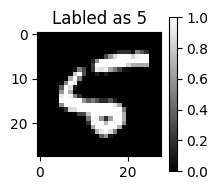

prediction: 2
distribution:
[[1.24024800e-080]
 [9.99355167e-001]
 [1.15090549e-010]
 [2.75881521e-030]
 [7.53446598e-059]
 [3.80205708e-046]
 [6.37443317e-004]
 [7.38923594e-006]
 [8.70960820e-107]
 [1.38891048e-056]]


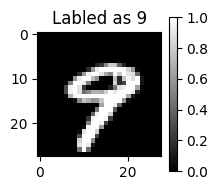

prediction: 8
distribution:
[[1.99209237e-94]
 [3.76641347e-19]
 [4.50056425e-04]
 [8.97873269e-27]
 [3.90717276e-50]
 [1.02022354e-43]
 [8.46309117e-07]
 [9.99549097e-01]
 [3.02080570e-81]
 [6.15860608e-49]]


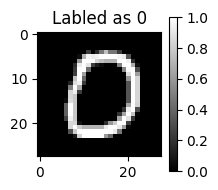

prediction: 3
distribution:
[[7.05522276e-79]
 [1.77896610e-11]
 [8.54988854e-01]
 [1.22723763e-23]
 [1.85268367e-45]
 [9.09051935e-39]
 [1.62016200e-05]
 [1.44994945e-01]
 [4.80983370e-79]
 [2.57645998e-46]]


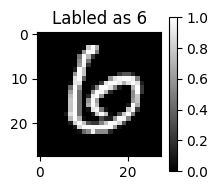

prediction: 8
distribution:
[[3.00350979e-60]
 [4.48906568e-03]
 [1.88653723e-05]
 [2.12318324e-19]
 [3.00461541e-40]
 [4.30285646e-30]
 [2.10754855e-01]
 [7.84737214e-01]
 [2.65728532e-70]
 [3.91421383e-39]]


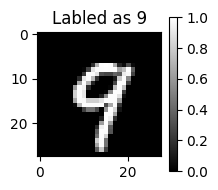

prediction: 8
distribution:
[[3.85011651e-80]
 [1.51952136e-06]
 [5.46723331e-03]
 [8.02570111e-26]
 [5.14500600e-53]
 [1.91230048e-43]
 [3.10347554e-05]
 [9.94500212e-01]
 [6.32540229e-86]
 [4.07615951e-47]]


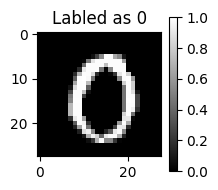

prediction: 3
distribution:
[[1.14988209e-44]
 [3.21975679e-07]
 [9.99993600e-01]
 [3.56350870e-14]
 [1.39615620e-36]
 [4.18330066e-26]
 [6.06438686e-06]
 [1.36664113e-08]
 [4.88999038e-50]
 [5.84694390e-28]]


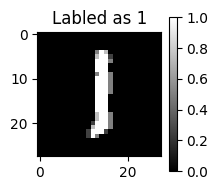

prediction: 3
distribution:
[[1.85662435e-60]
 [8.40755212e-09]
 [9.99978886e-01]
 [1.71095074e-17]
 [3.28749574e-46]
 [4.77496834e-35]
 [2.05839350e-05]
 [5.21510516e-07]
 [1.13461952e-65]
 [4.75384380e-36]]


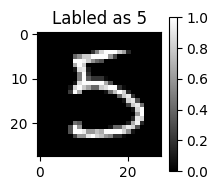

prediction: 3
distribution:
[[7.60115158e-60]
 [1.65988724e-05]
 [9.99973808e-01]
 [1.24580125e-22]
 [4.39977901e-48]
 [4.17639562e-37]
 [9.59281705e-06]
 [8.10033362e-12]
 [1.31359684e-76]
 [3.86061526e-43]]


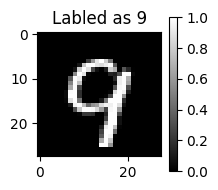

prediction: 3
distribution:
[[1.69612921e-59]
 [6.74377903e-03]
 [9.93238529e-01]
 [6.36606350e-19]
 [4.21005220e-48]
 [4.01903925e-35]
 [1.76910609e-05]
 [1.12267987e-09]
 [5.56492501e-74]
 [6.23681307e-41]]


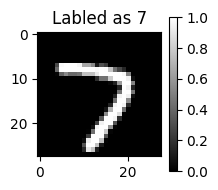

prediction: 8
distribution:
[[1.36911345e-137]
 [1.74624950e-024]
 [1.50792971e-034]
 [3.73379530e-059]
 [2.99467177e-063]
 [7.04071235e-064]
 [7.77873459e-013]
 [1.00000000e+000]
 [6.89532157e-133]
 [1.04746025e-082]]


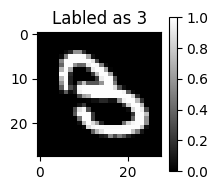

prediction: 3
distribution:
[[1.52245882e-42]
 [6.18213828e-06]
 [9.59991061e-01]
 [4.01970251e-11]
 [3.05797135e-30]
 [3.39903241e-22]
 [8.93607232e-03]
 [3.10666843e-02]
 [8.76552011e-42]
 [2.02203755e-23]]


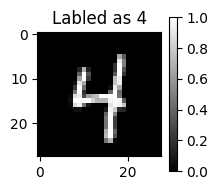

In [40]:
predict(x_test_final[0][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 0].reshape(-1, 1))+1)%10))
predict(x_test_final[1][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 1].reshape(-1, 1))+1)%10))
predict(x_test_final[2][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 2].reshape(-1, 1))+1)%10))
predict(x_test_final[3][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 3].reshape(-1, 1))+1)%10))
predict(x_test_final[4][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 4].reshape(-1, 1))+1)%10))
predict(x_test_final[5][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 5].reshape(-1, 1))+1)%10))
predict(x_test_final[6][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 6].reshape(-1, 1))+1)%10))
predict(x_test_final[7][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 7].reshape(-1, 1))+1)%10))
predict(x_test_final[8][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 8].reshape(-1, 1))+1)%10))
predict(x_test_final[9][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 9].reshape(-1, 1))+1)%10))
predict(x_test_final[10][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 10].reshape(-1, 1))+1)%10))
predict(x_test_final[11][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 11].reshape(-1, 1))+1)%10))
predict(x_test_final[12][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 12].reshape(-1, 1))+1)%10))
predict(x_test_final[13][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 13].reshape(-1, 1))+1)%10))
predict(x_test_final[14][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 14].reshape(-1, 1))+1)%10))
predict(x_test_final[15][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 15].reshape(-1, 1))+1)%10))
predict(x_test_final[16][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 16].reshape(-1, 1))+1)%10))
predict(x_test_final[17][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 17].reshape(-1, 1))+1)%10))
predict(x_test_final[18][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 18].reshape(-1, 1))+1)%10))
predict(x_test_final[19][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 19].reshape(-1, 1))+1)%10))

[[  0   0  21 157   0   0   0   7 795   0]
 [  0   0  61 848   0   0   0  72 154   0]
 [  0   0 120 157   0   0   0  25 730   0]
 [  0   0 120 155   0   0   0  34 701   0]
 [  0   0  75 265   0   0   0  86 556   0]
 [  0   0 111 150   0   0   0  54 577   0]
 [  0   0 118  71   0   0   0  53 716   0]
 [  0   0 157 259   0   0   0 245 367   0]
 [  0   0  27 129   0   0   0  29 789   0]
 [  0   0  84 224   0   0   0 200 501   0]]


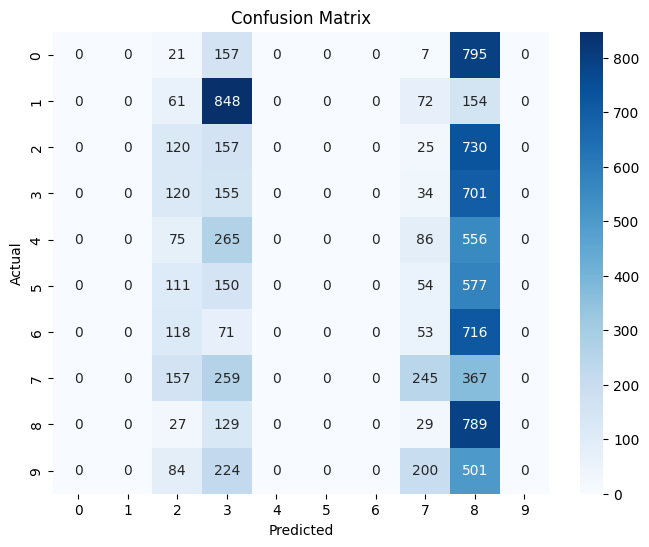


Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
           1     0.0000    0.0000    0.0000      1135
           2     0.1342    0.1163    0.1246      1032
           3     0.0642    0.1535    0.0905      1010
           4     0.0000    0.0000    0.0000       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.3043    0.2383    0.2673      1028
           8     0.1340    0.8101    0.2300       974
           9     0.0000    0.0000    0.0000      1009

    accuracy                         0.1309     10000
   macro avg     0.0637    0.1318    0.0712     10000
weighted avg     0.0647    0.1309    0.0719     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
## Model Accuracy on Unseen Test Data
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_true = []
y_pred = []

for i in range(0, x_test_final.shape[0]):
  y_true.append(((np.argmax(y_test_labels[:, i].reshape(-1, 1))+1)%10))
  y_pred.append(predict_for_scoring(x_test_final[i][:].reshape(-1, 1)))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print("\nClassification Report:")
print(report)


In [ ]:
## NOTES
# idk best practice in Python - fix erorr handling
# note (take out) would optimize this process if fr (backprop calc section)
# how do we use error of layer 0?
# allow learning rate sceduling
# if grad_descent takes too long try mini-batching
# matplotlib visualization about how many of the parameters are w1
# training took. so long. one epoch took over 3 minutes on a t4. need to optimize. started by implementing mini-batching
# changed to selecting 32 random examples to train on for each of 200 epochs. This model trained in 5 seconds on GPUs and produced predictions of '8' for every single example
# implemented a print line that tells me the cost for each batch of examples - not improving - something wrong with gradient equations I think
# takeaways - hyperparameter tuning is even more important than I thought